# Installing

- segmentation-models

    Used for creating segmentation model

# Documentation
https://github.com/qubvel/segmentation_models

In [1]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 1.8 MB/s eta 0:00:00


# Imports

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [3]:
BASE_PATH = "../input/uw-madison-gi-tract-image-segmentation"
TRAIN_IMAGES_PATH = os.path.join(BASE_PATH, "train")
TRAIN_CSV_PATH = os.path.join(BASE_PATH, "train.csv")
TEST_PATH = os.path.join(BASE_PATH, "test")

In [4]:
input_data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomContrast(0.1),
    ]
)

2022-05-15 07:28:55.888090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 07:28:56.020271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 07:28:56.021057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 07:28:56.023683: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Dataset Generator

This will load the dataset and apply transformation based on requirements

In [5]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, path, augmentation=True, batch_size=4, shuffle=True, size=(256, 256), csv_path=None):
        self.path = path
        self.size = size
        self.augmentation = augmentation
        self.load_images_paths()
        
        # Our classes
        self.classes = ["background","large_bowel", "small_bowel", "stomach"]

        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.keys = list(self.images.keys())
        self.n = len(self.keys)
        self.indexes = np.array(list(range(self.n)))
        
        if self.shuffle:
            np.random.shuffle(self.indexes)

        if csv_path:
            self.csv_path = csv_path
            self.load_csv()
    
    def load_images_paths(self):
        '''Loading All Slices paths only
        '''
        self.images = {}
        for c1 in os.listdir(self.path):
            path1 = os.path.join(self.path, c1)
            for c2 in os.listdir(path1):
                path2 = os.path.join(path1, c2, "scans")
                for c3 in os.listdir(path2):
                    path3 = os.path.join(path2, c3)
                    self.images[f"{c2}_{self.get_slice_name(c3)}"] = {"path": path3,
                                                                     "class": [],
                                                                     "segmentation": [],
                                                                     "size": (0 , 0)}

    def get_slice_name(self, image_name):
        image_name = image_name.split("_")
        return f"{image_name[0]}_{image_name[1]}"

    def load_csv(self):
        '''Load CSV for output labels
        '''
        self.csv_data = pd.read_csv(self.csv_path).values
        
        for v in self.csv_data:
            self.images[v[0]]["class"].append(v[1])
            self.images[v[0]]["segmentation"].append(v[2])
    
    def decode_segmentation(self, idx):
        '''Convert CSV Labels to segmenation images
        '''
        values_list = self.images[idx]["segmentation"]
        labels = self.images[idx]["class"]
        size = self.images[idx]["size"]
        
        image = np.zeros(size[0] * size[1], dtype=np.uint8)
        
        for values, lbl in zip(values_list, labels):
            if not type(values) == str:
                continue
            
            lbl_id = self.classes.index(lbl)
            values = values.split()
            starts, lengths = [np.asarray(x, dtype=int) for x in (values[0:][::2], values[1:][::2])]
            starts -= 1
            ends = starts + lengths
            for lo, hi in zip(starts, ends):
                image[lo: hi] = lbl_id

        result = image.reshape(size)
        return result

    def load_image(self, idx):
        filename = self.images[idx]["path"]
        img = cv2.imread(filename, cv2.CV_16UC1)
        self.images[idx]["size"] = img.shape
        return img
    
    def normalize(self, img):
        '''Normalize input images
        '''
        return (img-np.min(img)) / (np.max(img)-np.min(img))
    
    def padding(self, img, seg):
        '''Padd images to make them same size'''
        h, w = img.shape
        size = np.max([h, w])
        new_img = np.zeros((size, size))
        new_seg = np.zeros((size, size), dtype="uint8")

        pady = (size-h)//2
        padx = (size-w)//2

        new_img[pady:pady+h, padx:padx+w] = img
        new_seg[pady:pady+h, padx:padx+w] = seg

        return new_img, new_seg

    def mask_resize(self, seg):
        '''resize mask
        class labels are in the form of one hot encoding, but the are inside image pixels.
        '''
        labels = np.unique(seg)
        
        new_seg = np.zeros((self.size[0], self.size[1], 4))
        for l in labels:
            if l == 0:
                continue
            temp_seg = seg.copy()
            temp_seg[temp_seg != l] = 0
            temp_seg[temp_seg == l] = 1
            temp_seg = cv2.resize(temp_seg, (self.size))
            new_seg[:, :, l] = temp_seg
        return new_seg
        
    def preprocess(self, img, seg):
        img, seg = self.padding(img, seg)
        img = cv2.resize(img, (self.size))
        img = self.normalize(img)
        img2 = np.zeros((img.shape[0], img.shape[1], 3))
        img2[:, :, 0] = img
        img2[:, :, 1] = img
        img2[:, :, 2] = img
        seg = self.mask_resize(seg)
        return img2, seg

    def get_single_samples(self, idx):
        idx = self.keys[idx]
        img = self.load_image(idx)
        seg = self.decode_segmentation(idx)
        return img, seg

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.keys)

    def __get_data(self, batches):
        # Generates data containing batch_size samples
    
        X_batch = [] # input list
        y_batch = [] # output list

        for indx in batches: # loop to create new batch
            keys = self.keys[indx]
            img = self.load_image(keys)
            seg = self.decode_segmentation(keys)
            img, seg = self.preprocess(img, seg)
#             img = input_data_augmentation(img)
#             seg = seg_data_augmentation(seg)
            X_batch.append(img)
            y_batch.append(seg)

        return np.array(X_batch, dtype="float32"), np.array(y_batch, dtype="float32")

    def __getitem__(self, index):
        # get name of the files for current batch
        batches = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # load images from file name
        return self.__get_data(batches)
    
    def __call__(self):
        for i in self.indexes:
            yield self.__getitem__(i)

    def __len__(self):
        return self.n // self.batch_size

In [6]:
train_data = Dataset(path=TRAIN_IMAGES_PATH, csv_path=TRAIN_CSV_PATH, batch_size=8)

# Preview Dataset

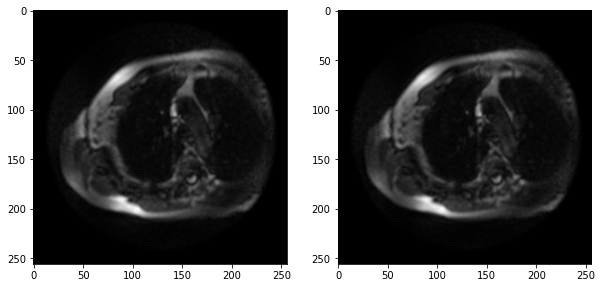

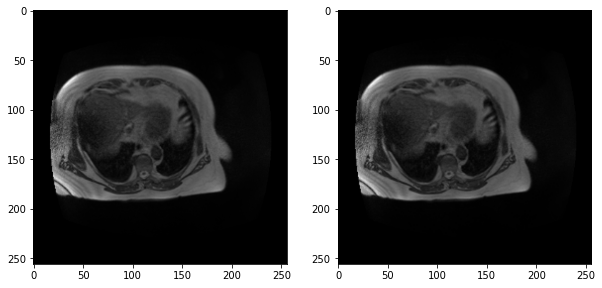

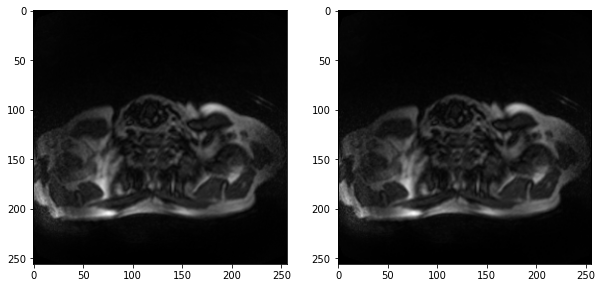

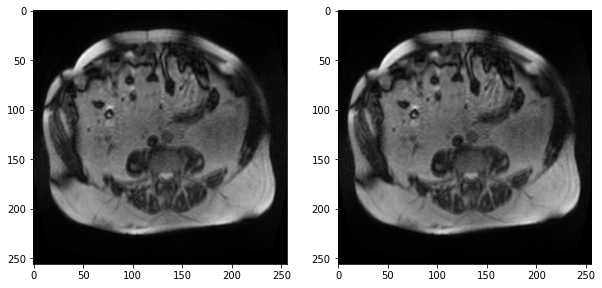

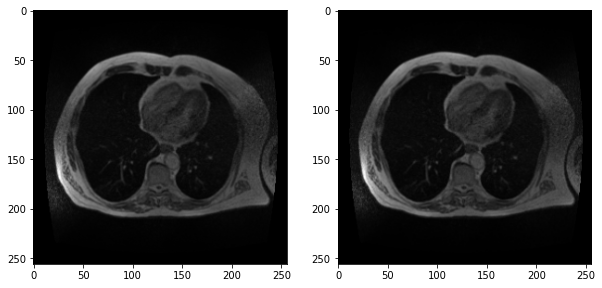

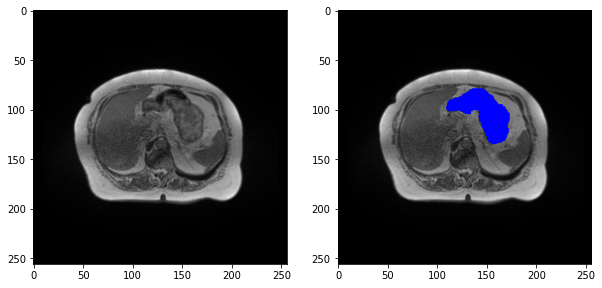

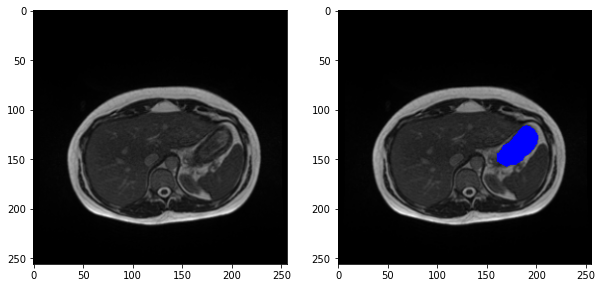

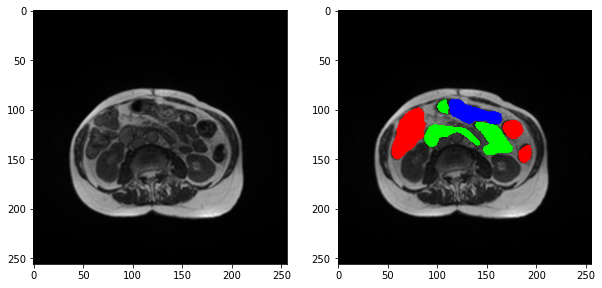

In [7]:
images, segms = next(iter(train_data))
for img, seg in zip(images, segms):
    img2 = img.copy()
    img2 = (img2-np.min(img2))/(np.max(img2)-np.min(img2))
    img2 = np.array(img2*255, dtype="uint8")
    # Class 1 shown as Red
    img2[seg[:, :, 1] == 1] = (255, 0, 0)
    # Class 2 shown as Green
    img2[seg[:, :, 2] == 1] = (0, 255, 0)
    # Class 3 shown as Blue
    img2[seg[:, :, 3] == 1] = (0, 0, 255)
    
    plt.figure(figsize=(10, 10))
    
    all_imgs = [img,
#                 seg[:, :, 1],
#                 seg[:, :, 2],
#                 seg[:, :, 3],
                img2]

    for indx, data in enumerate(all_imgs):
        plt.subplot(1,len(all_imgs), indx+1)
        plt.imshow(data)
    plt.show()

# Segmentation model

In [8]:
import segmentation_models as sm
import tensorflow.keras as keras
# or from tensorflow import keras
sm.set_framework('tf.keras')

sm.framework()
# keras.backend.set_image_data_format('channels_last')
# or keras.backend.set_image_data_format('channels_first')

Segmentation Models: using `keras` framework.


'tf.keras'

# Initialize Models Parameters

In [9]:
# define optomizer
LR = 1e-4
optim = keras.optimizers.Adam(LR)

n_classes = 4
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model = sm.FPN('efficientnetb3', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

44122112/44107200 [==============================] - 2s 0us/step


In [10]:
# model.load_weights("model.hdf5")

# Training Model

- Require GPU (otherwise it will take 7 Hours for 1 epoch)
    - Kaggle proive 30 Hours of GPU (18 Minute with Kaggel GPU for each epoch)

In [11]:
model.fit(train_data,
          epochs=30,
          verbose=2,
          callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='model_FPN_{epoch:02d}.h5', save_weights_only=True),
                     tf.keras.callbacks.ModelCheckpoint(filepath='model_FPN_.h5', save_weights_onlu=True)])

2022-05-15 07:29:13.041904: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-05-15 07:29:28.667442: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4812/4812 - 1339s - loss: 0.5321 - iou_score: 0.4025 - f1-score: 0.4927


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
4812/4812 - 1284s - loss: 0.4565 - iou_score: 0.4975 - f1-score: 0.5776
Epoch 3/30
4812/4812 - 1288s - loss: 0.4321 - iou_score: 0.5190 - f1-score: 0.5958
Epoch 4/30
4812/4812 - 1286s - loss: 0.4124 - iou_score: 0.5244 - f1-score: 0.6010
Epoch 5/30
4812/4812 - 1285s - loss: 0.4035 - iou_score: 0.5289 - f1-score: 0.6050
Epoch 6/30
4812/4812 - 1285s - loss: 0.4038 - iou_score: 0.5280 - f1-score: 0.6041
Epoch 7/30
4812/4812 - 1286s - loss: 0.4018 - iou_score: 0.5293 - f1-score: 0.6050
Epoch 8/30
4812/4812 - 1284s - loss: 0.3884 - iou_score: 0.5444 - f1-score: 0.6178
Epoch 9/30
4812/4812 - 1283s - loss: 0.3879 - iou_score: 0.5455 - f1-score: 0.6178
Epoch 10/30
4812/4812 - 1284s - loss: 0.3849 - iou_score: 0.5479 - f1-score: 0.6204
Epoch 11/30
4812/4812 - 1285s - loss: 0.3825 - iou_score: 0.5515 - f1-score: 0.6230
Epoch 12/30
4812/4812 - 1285s - loss: 0.3772 - iou_score: 0.5573 - f1-score: 0.6273
Epoch 13/30
4812/4812 - 1286s - loss: 0.3793 - iou_score: 0.5559 - f1-score: 0.6260
